In [34]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scienceplots

In [26]:
def readWallCurrent(fileName):
    f = h5py.File(fileName,'r')
    xZero=f['ch1']['xZero'][0]
    xIncr=f['ch1']['xIncr'][0]
    frames=f['ch1']['frames']
    numFrames=f['ch1']['frames'].shape[0]
    numPoints=f['ch1']['frames'].shape[1]
    yMult=f['ch1']['yMult'][0]
    yOffset=f['ch1']['yOffset'][0]
    yZero=f['ch1']['yZero'][0]
    time = np.arange(xZero, xZero + (xIncr*numPoints), xIncr)
    y = frames*yMult
    return time, y

(6250,)


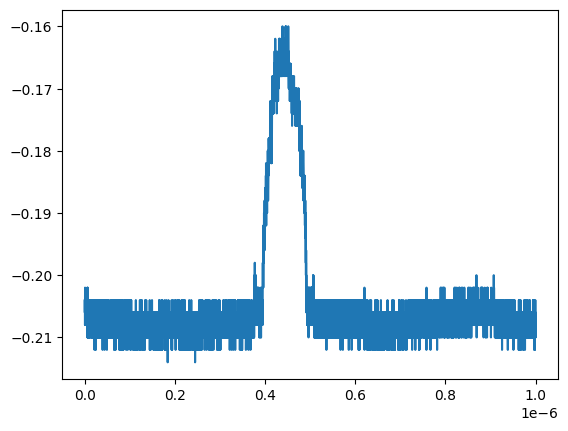

In [29]:
fileName = r'C:\\Users\bengl\Documents\summerIntern\data_studies\incoherent_tune_shift\4turns0.h5'
time, y = readWallCurrent(fileName)
print(y[1000].shape)
plt.plot(time,y[15])

In [83]:
# Gaussian function for fit
def gaussian(x, amplitude, mean, std_dev, c):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2)) + c

def linear_func(x, a, b):
    return a * x + b

def ytime(skip=[],debug=False):

    booster_turns = [4,6,8,10,11,14]
    Num=1000
    Max_Frequency = np.zeros((len(booster_turns),5))
    Intensity = np.zeros((len(booster_turns),5))
    
    Intensity_Avg = np.zeros(len(booster_turns))
    Intensity_Std = np.zeros(len(booster_turns))
    Max_Frequency_Avg = np.zeros(len(booster_turns))
    Max_Frequency_Std = np.zeros(len(booster_turns))

    for t, turns in enumerate(booster_turns):
        for repeat in range(5):
            if (str(turns)+"."+str(repeat)) in skip:
                continue
            # Calculate average intensity in the 0.04s around 0.57s

            try:
                intensity_data = np.loadtxt(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\' + str(turns) + r'turns'+str(repeat)+'_beam')
                mask = (intensity_data[0:,0] > 0.55) & (intensity_data[0:,0] < 0.59)
                Averaged_Intensity = np.mean(intensity_data[0:,1][mask])
                Intensity[t][repeat] = Averaged_Intensity
            except:
                pass
                #print('no intensity data for', turns, 'turns', repeat, 'repeat')

            try:
                time, y = readWallCurrent(r'C:\\Users\bengl\Documents\summerIntern\data_studies\incoherent_tune_shift\\'+str(turns)+r'turns' +str(repeat)+'.h5')
            except:
                continue
       
    
            # Look in certain range
            mask = (time>0.2e-6) & (time<0.7e-6)
            time_range = time[mask]
            y_range = y[Num][mask]

            # Fit a gaussian to the peak
            p0 = [0.2, 0.43e-6, 0.005e-6, -0.20]  # Initial guess for the parameters
            lower_bounds = [0, 0.4e-6, 0, -1]
            upper_bounds = [5, 0.5e-6, 0.4e-6, 1]
            bounds = (lower_bounds, upper_bounds)
            fit_params, _ = curve_fit(gaussian, time_range, y_range, p0=p0, bounds=bounds)
            amplitude_fit, mean_fit, std_dev_fit, c_fit = fit_params
            fitted_curve = gaussian(time_range, amplitude_fit, mean_fit, std_dev_fit, c_fit)

            # Plotting
            if debug==True:
                plt.plot(time_range, y_range, label='Fourier Transformed Data')
                plt.plot(time_range, fitted_curve, label='Fitted Curve')
                plt.title('Position with ' + str(turns) + ' Booster Turns')
                plt.xlabel('Position')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.show()
            
            
            # In case only one data point
            Max_Frequency_Avg[t] = mean_fit            
            
            Max_Frequency[t][repeat] = mean_fit
            
            
    
    
    # Remove rows if no data for that booster turn        
    # Create a boolean mask indicating which rows contain all zeros
    mask = np.any(Intensity != 0, axis=1)

    # Use the mask to select the rows without all zeros
    Intensity = Intensity[mask]
    Max_Frequency = Max_Frequency[mask]
    Max_Frequency_Avg = Max_Frequency_Avg[mask]
    Max_Frequency_Std = Max_Frequency_Std[mask]
    Intensity_Avg = Intensity_Avg[mask]
    Intensity_Std = Intensity_Std[mask]

    for i in range(Intensity.shape[0]):
        I_list = Intensity[i,:][Intensity[i,:]>0]
        if len(I_list) == 1:
            continue
        else:
            Intensity_Std[i] = np.std(I_list)
            Intensity_Avg[i] = np.mean(I_list)

            list = Max_Frequency[i,:][Max_Frequency[i,:]>0]
            Max_Frequency_Avg[i] = np.mean(list)
            Max_Frequency_Std[i] = np.std(list)
    
    # Set the STD of the Intensity to the maximum of the others (if only one data point)
    for i in range(Intensity.shape[0]):
        I_list = Intensity[i,:][Intensity[i,:]>0]
        if len(I_list) == 1:
            print("Using max intensity error of others for turns", booster_turns[i])
            Intensity_Std[i]=max(Intensity_Std)
            Intensity_Avg[i]=I_list[0]

        list = Max_Frequency[i,:][Max_Frequency[i,:]>0]
        if len(list)==1:
            print("Using max frequency error of others for turns", booster_turns[i])
            Max_Frequency_Std[i]=max(Max_Frequency_Std)
            Max_Frequency_Avg[i]=list[0]
          
    
    params, _ = curve_fit(
    linear_func, Intensity_Avg, Max_Frequency_Avg, sigma=Max_Frequency_Std, absolute_sigma=True
    )
    # Extract the fitted parameters
    a, b = params
    # Plot
    fig, ax = plt.subplots(figsize=(6,4), dpi=800)
    plt.xlabel(r'E $\times 10^{12}$ (ppb)')
    plt.ylabel('Position')
    plt.title('Position vs Intensity')
    plt.errorbar(Intensity_Avg,Max_Frequency_Avg,xerr=Intensity_Std,yerr=Max_Frequency_Std, fmt='x', markersize=3, markeredgewidth=0.5, ecolor='black', capsize=2, elinewidth=0.5, capthick=0.5)
    plt.plot(Intensity_Avg,a*np.array(Intensity_Avg)+b, label='Linear Fit', color='red', linewidth=0.5)
    plt.show()


Using max intensity error of others for turns 4
Using max frequency error of others for turns 4


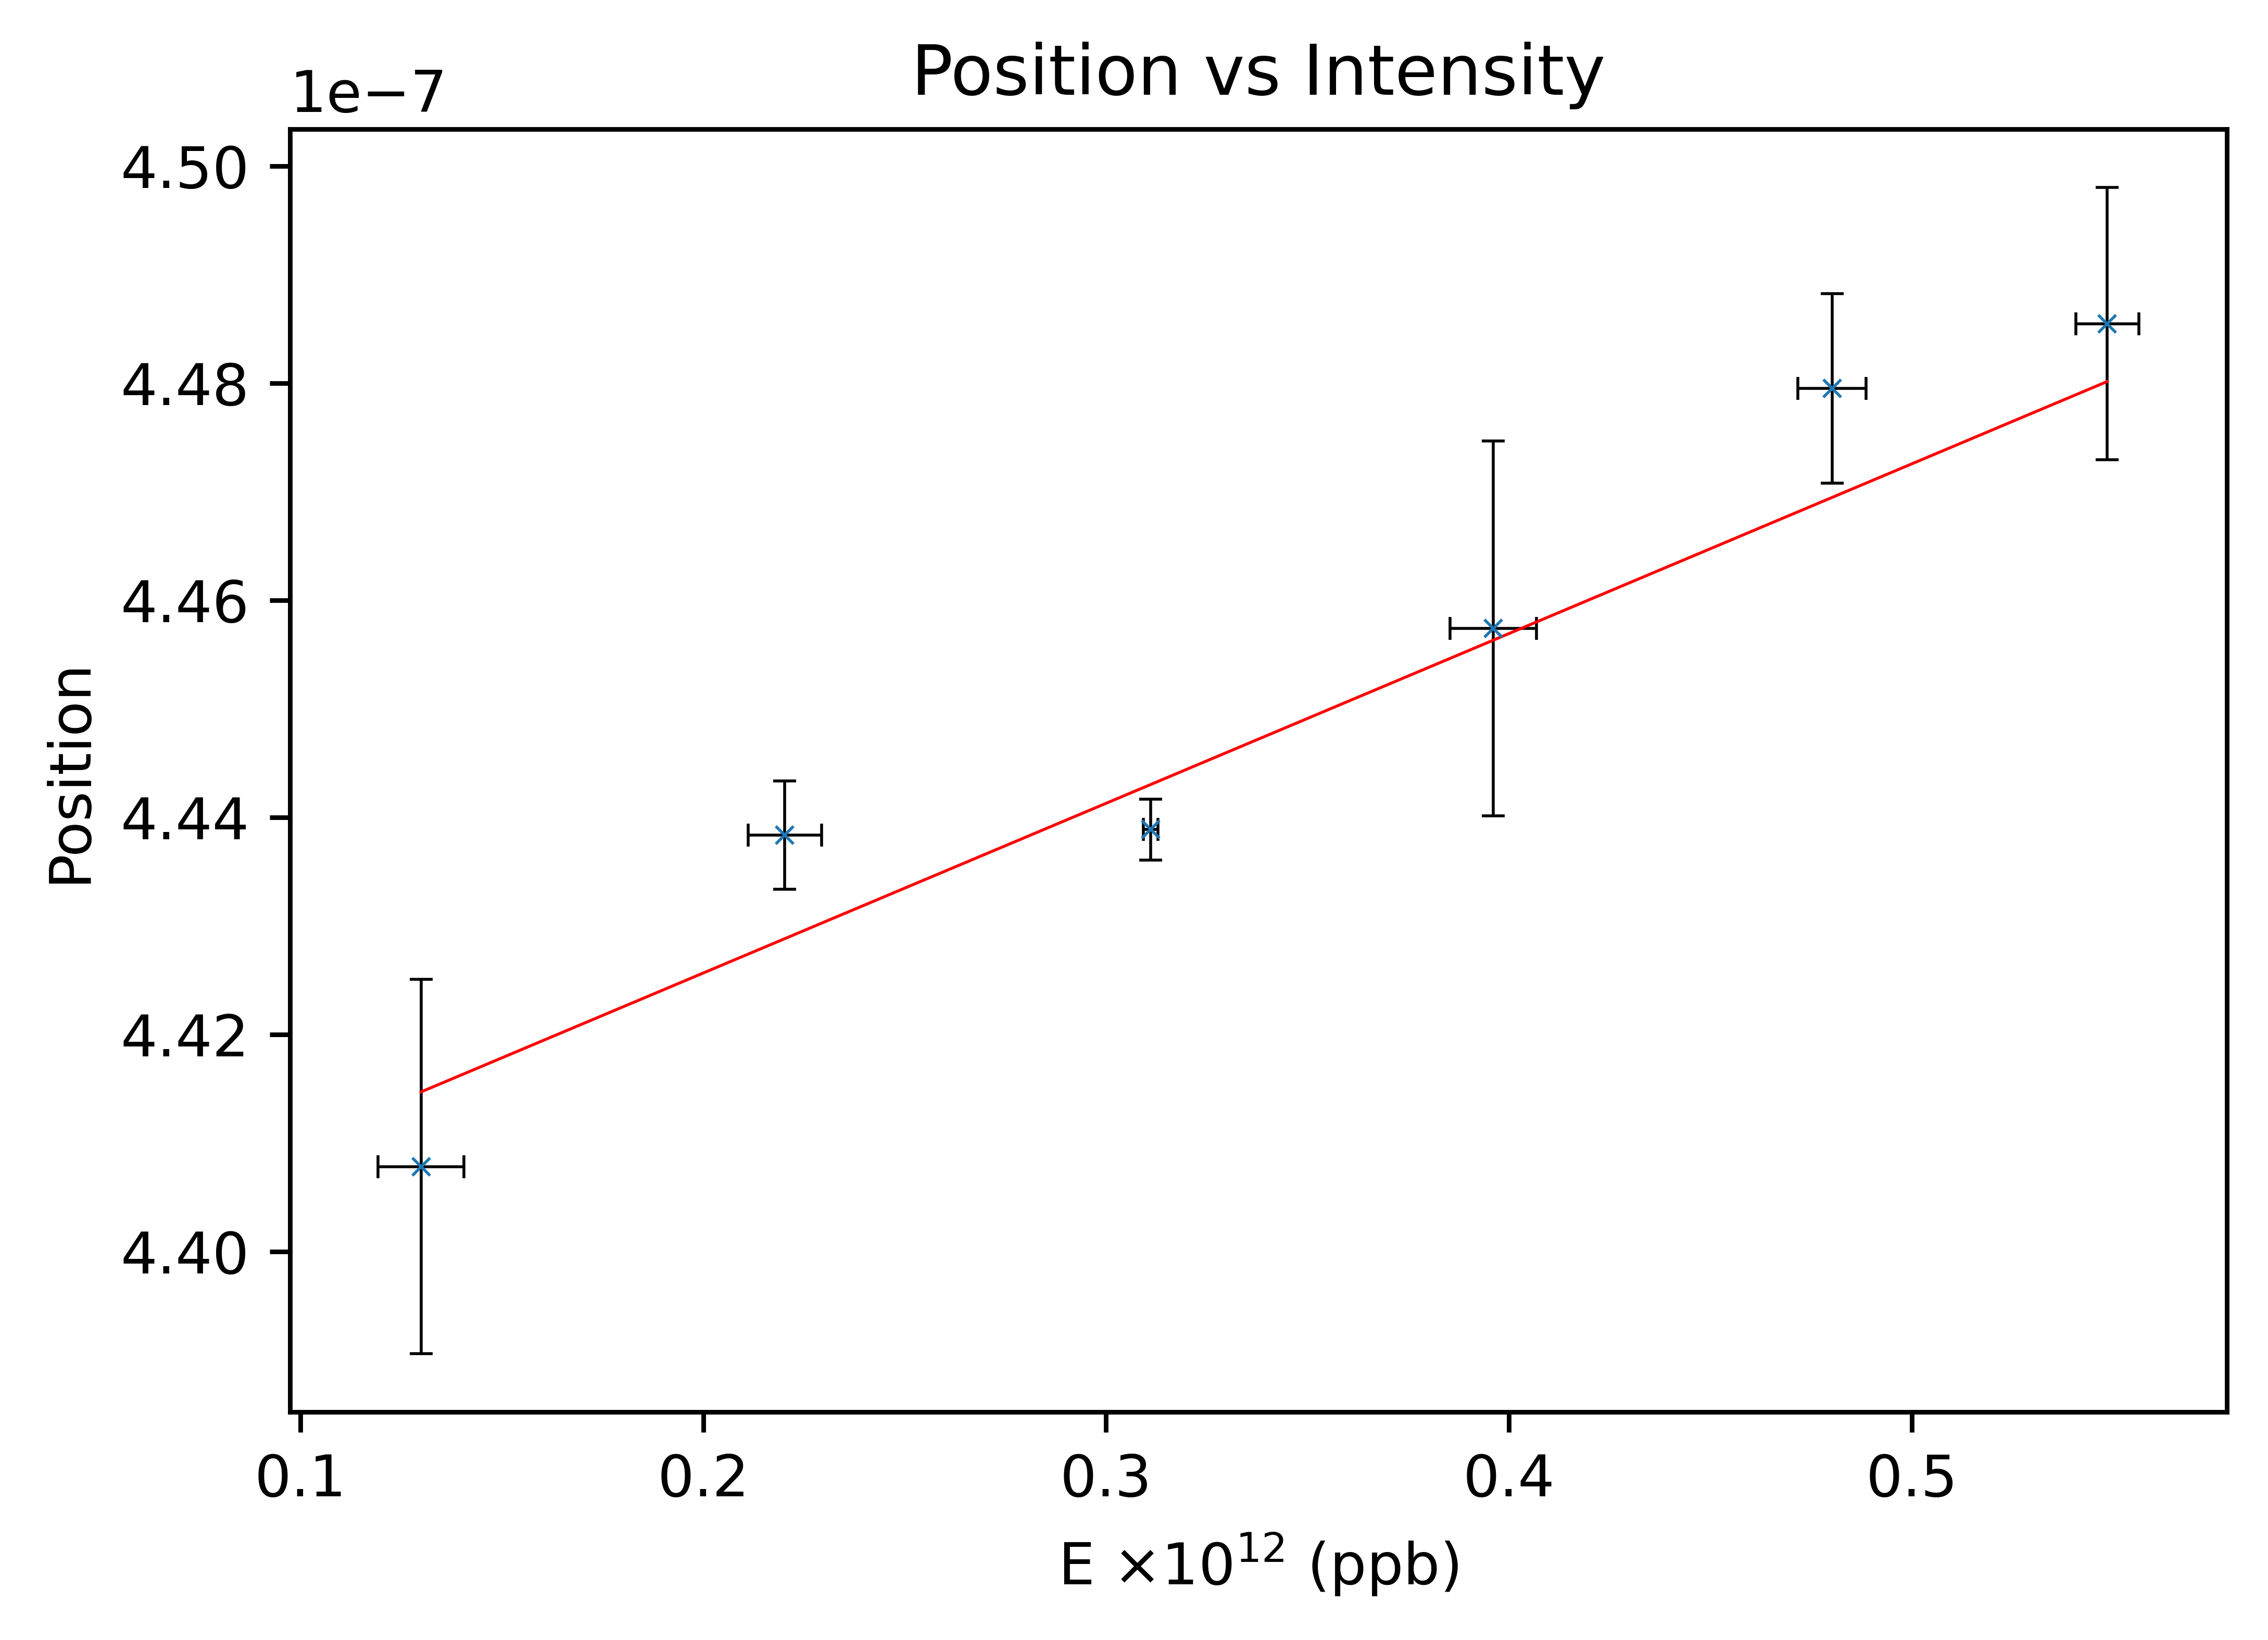

In [84]:
ytime()